In [1]:
import numpy as np
import argparse
import omegaconf 
import os
from PIL import Image
import torchvision.transforms as transforms
import joblib
import matplotlib.pyplot as plt
from model.BrownianBridge.LatentBrownianBridgeModel import LatentBrownianBridgeModel
import yaml

NUM_LABELS = 10

CKPT_PATH = f'/home/PET-CT/thaind/kmeans/ckpts_kmeans_latent/kmeans_model_k={NUM_LABELS}.joblib'
DATA_PATH = '/home/PET-CT/splited_data_15k/train/A'
CT_MAX = 2047
IMAGE_SIZE = 256

/root/anaconda3/envs/BBDM/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def dict2namespace(config):
    namespace = argparse.Namespace()
    for key, value in config.items():
        if isinstance(value, dict) or isinstance(value, omegaconf.dictconfig.DictConfig):
            new_value = dict2namespace(value)
        else:
            new_value = value
        setattr(namespace, key, new_value)
    return namespace

def get_image_paths_from_dir(fdir):
    flist = os.listdir(fdir)
    flist.sort()
    image_paths = []
    for i in range(0, len(flist)):
        fpath = os.path.join(fdir, flist[i])
        if os.path.isdir(fpath):
            image_paths.extend(get_image_paths_from_dir(fpath))
        else:
            image_paths.append(fpath)
    return image_paths

def make_dir(dir):
    os.makedirs(dir, exist_ok=True)
    return dir

In [3]:
ct_paths = get_image_paths_from_dir(os.path.join(DATA_PATH))
    
transform = transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])
    
f = open('/home/PET-CT/thaind/BBDM_folk/configs/Template_CPDM.yaml', 'r')
dict_config = yaml.load(f, Loader=yaml.FullLoader)

nconfig = dict2namespace(dict_config)
ltbbdm = LatentBrownianBridgeModel(nconfig.model).to('cuda:0')
ltbbdm.eval()

kmeans_model = joblib.load(CKPT_PATH)

labels_map = {}

for ct_path in ct_paths:
    ct_image = np.load(ct_path, allow_pickle=True)
    ct_image = ct_image / float(CT_MAX)
    
    ct_image = Image.fromarray(ct_image) 
    ct_image = transform(ct_image) 
    ct_image = ct_image.unsqueeze(0).to('cuda:0')
    ct_image = ltbbdm.encode(ct_image)
    ct_image = ct_image.cpu().numpy()
    ct_image = ct_image.flatten()
    ct_image = np.array([ct_image])
    
    label = kmeans_model.predict(ct_image)[0]
    
    if label not in labels_map:
        labels_map[label] = []
        
    labels_map[label].append(ct_path)

Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
Restored from /home/PET-CT/vqgan/vq1_3_69.ckpt
load vqgan from /home/PET-CT/vqgan/vq1_3_69.ckpt
Spatial Rescaler mapping from 1 to 3 channels after resizing.
Spatial Rescaler mapping from 1 to 3 channels after resizing.


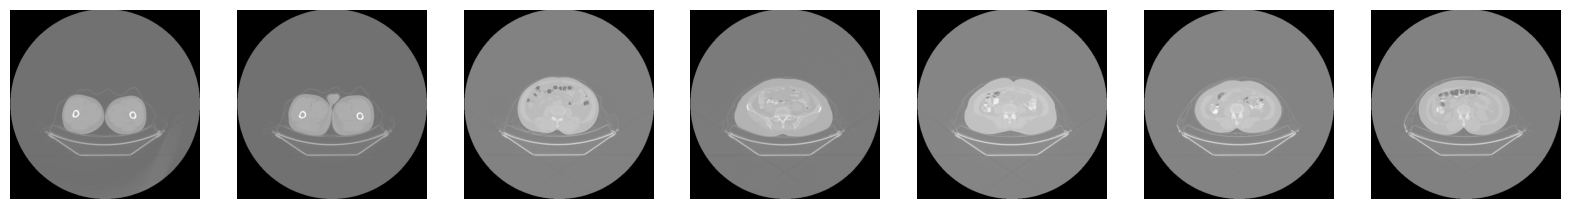

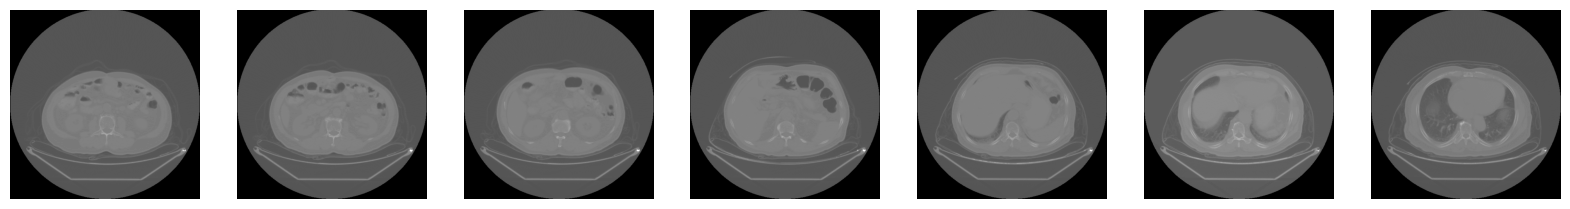

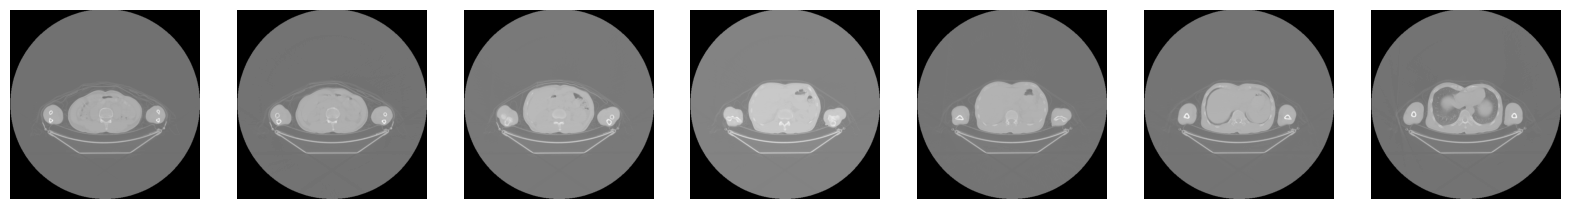

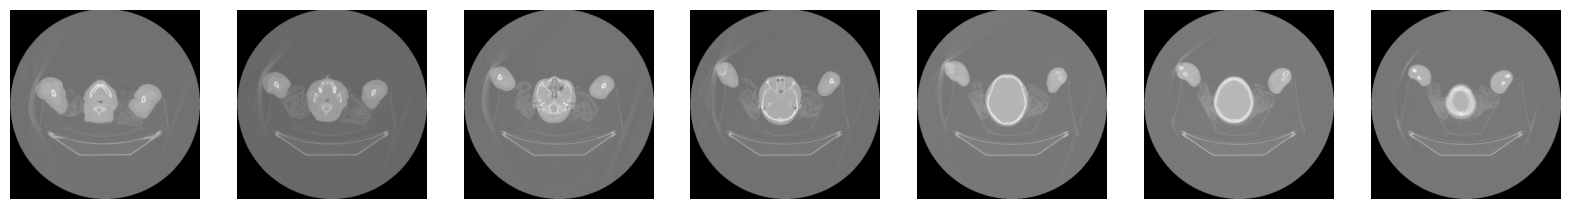

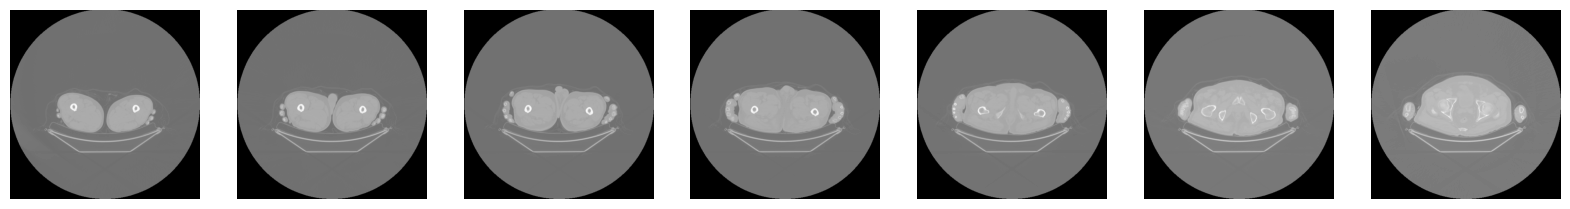

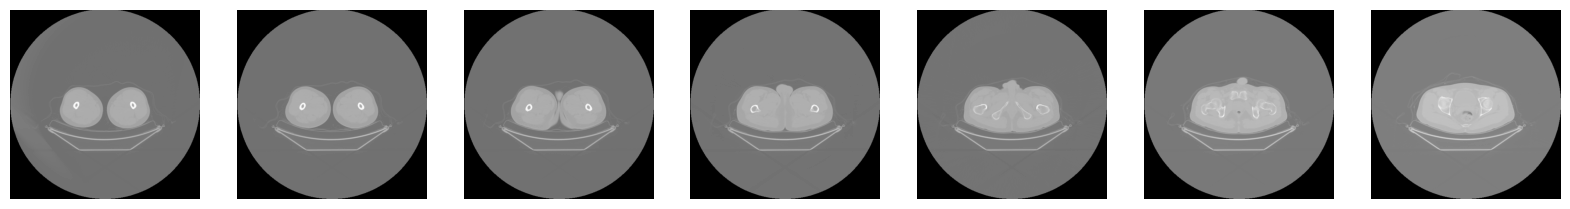

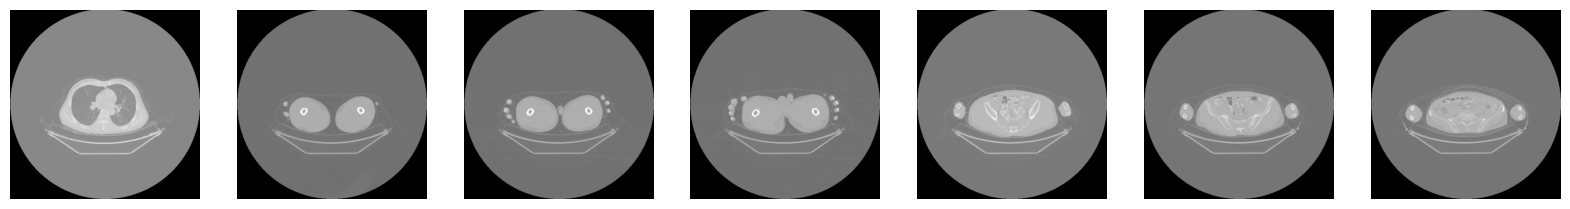

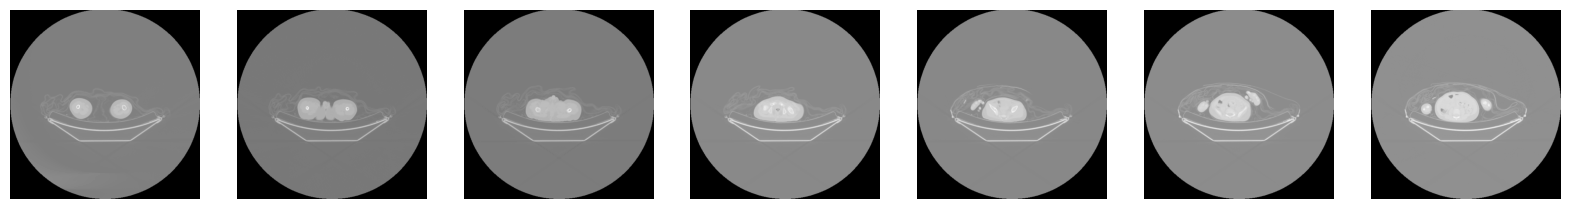

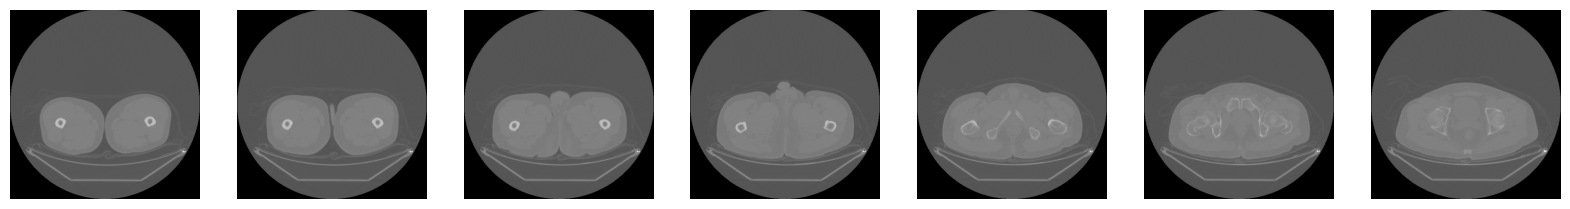

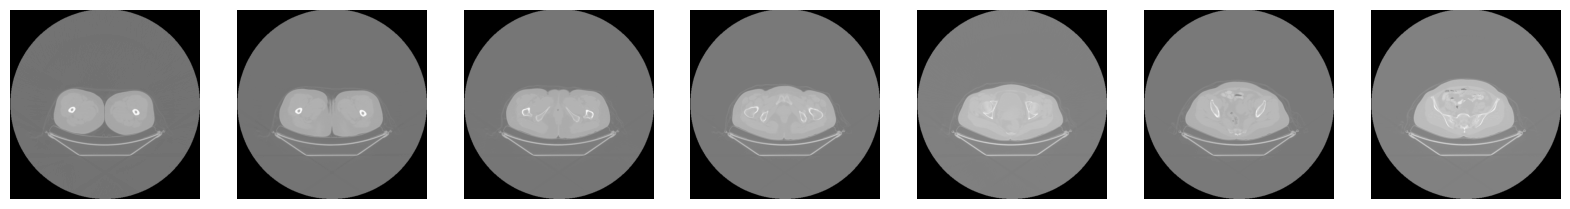

In [4]:
NUM_DISPLAY = 7

for k in range(0, NUM_LABELS):
    fig, axs = plt.subplots(1, NUM_DISPLAY, figsize=(20, 4))
    # fig.suptitle(f'Cluster {k}')
    
    for i in range(0, NUM_DISPLAY):
        if i < len(labels_map[k]):  
            ct_image_path = labels_map[k][i]
            ct_image = np.load(ct_image_path, allow_pickle=True)
            ct_image = ct_image / float(CT_MAX)  

            axs[i].imshow(ct_image, cmap='gray')  
            axs[i].axis('off')  
        else:
            axs[i].axis('off')  
    
    plt.show()